# Pendulum motion with Forward Euler

[AMath 586, Spring Quarter 2019](http://staff.washington.edu/rjl/classes/am586s2019/) at the University of Washington. For other notebooks, see [Index.ipynb](Index.ipynb) or the [Index of all notebooks on Github](https://github.com/rjleveque/amath586s2019/blob/master/notebooks/Index.ipynb).

This notebook illustrates how Forward Euler behaves when modeling a simple pendulum on a coarse grid.


In [5]:
%matplotlib inline

In [10]:
from pylab import *
from matplotlib import animation
from IPython.display import HTML
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from tqdm import tqdm

## Compute a fine grid solution for comparison:

In [7]:
def f(t,u):
    f0 = u[1]
    f1 = -sin(u[0])
    return array([f0,f1])

theta0 = pi/2.
u0 = array([theta0, 0.])
tf = 30.

t_span = (0., tf)
t_eval = linspace(0, tf, 1000)
solution = solve_ivp(f, t_span, u0, method='RK45', t_eval=t_eval, 
                      atol=1e-9, rtol=1e-9)
theta_eval = solution.y[0,:]

## Forward Euler implementation:

Error at the final time = 18.1484


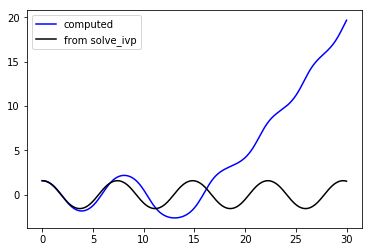

In [8]:
def ForwardEuler(nsteps):
    t0 = 0.;  tfinal = 30.
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    # Array for computed solution
    # give it two rows so each column is solution at one time,
    
    U = empty((2,nsteps+1))
    U.fill(nan)
    U[0,0] = theta0  # initial angle theta
    U[1,0] = 0.  # initial angular velocity
    for n in range(0,nsteps):
        U[0,n+1] = U[0,n] + dt * U[1,n]
        U[1,n+1] = U[1,n] - dt * sin(U[0,n])
    
    return t,U

t,U = ForwardEuler(300)

plot(t,U[0,:],'b',label='computed')
plot(t_eval,theta_eval,'k',label='from solve_ivp')
legend()
print('Error at the final time = %g' % abs(U[0,-1]-theta_eval[-1]))

Note that the Forward Euler solution for $\theta(t)$ grows in amplitude with time in a nonphysical manner and eventually goes over the top ($\theta > \pi$) and continues swinging around and around rather than osciallating about $\theta = 0$ as it should.

This is much easier to visualize in an animation...


## Animation

The rest of this notebook shows how to make an animation of the solution. 

This uses the [animation.FuncAnimation](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html) function from matplotlib to animate the pendulum motion.  See e.g. [this page](http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/) for a nice simple introductory example.

In [ ]:
def pend_animation(nsteps, plot_interval=1):
    """
    Solve the pendulum problem with the method defined above using nsteps time steps.
    Create an animation showing the swinging pendulum, using the solution every
    plot_interval time steps.
    """
   
    # compute the solution with the method define above:
    t,U = ForwardEuler(nsteps)
    
    fig = plt.figure(figsize=(11,5))
    ax1 = plt.subplot(121)
    plot(t,U[0,:],'r')
    pi_ticks = pi*array([-1,0,1,2,3,4,5,6])
    pi_labels = ['$-\pi$','0','$\pi$','$2\pi$','$3\pi$','$4\pi$','$5\pi$','$6\pi$']
    ax1.set_yticks(pi_ticks)
    ax1.set_yticklabels(pi_labels)
    ax1.set_xlabel('time')
    ax1.set_ylabel('theta')
    ax1.grid(True)
    
    theta = U[0,0]
    pendlength = 2.
    xpend = pendlength*sin(theta);
    ypend = -pendlength*cos(theta);
    
    ax2 = plt.subplot(122,xlim=(-2.3, 2.3), ylim=(-2.3, 2.3))
    ax2.plot([-2.3,2.3],[0,0],'k',linewidth=0.5)
    ax2.plot([0,0],[-2.3,2.3],'k',linewidth=0.5)
    axis('scaled')
    ax2.set_xlim(-2.3,2.3)
    ax2.set_ylim(-2.3,2.3)
    
    def init():
        shaft, = ax2.plot([0,xpend], [0,ypend], linestyle='-', color='lightblue', lw=2)
        bob, = ax2.plot([xpend],[ypend],'o',color='lightblue', markersize=8)
        theta_pt, = ax1.plot([t[0]], [U[0,0]], 'o',color='pink')
        return (shaft,bob,theta_pt)

    shaft,bob,theta_pt = init()
    
    def fplot(n):
        theta = U[0,n]
        xpend = pendlength*sin(theta);
        ypend = -pendlength*cos(theta);
        shaft.set_data([0,xpend], [0,ypend])
        shaft.set_color('b')
        bob.set_data([xpend], [ypend])
        bob.set_color('b')
        theta_pt.set_data([t[n]], [U[0,n]])
        theta_pt.set_color('k')
        return (shaft,bob,theta_pt)

    frames_to_plot = range(0, len(t), plot_interval)
    close(fig)
    return animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True,init_func=init,repeat=False)


In [ ]:
anim = pend_animation(300,3);

In [ ]:
HTML(anim.to_jshtml())

# Backward Euler implementation

Here we implement the Backward Euler method 

Error at the final time = 1.89806


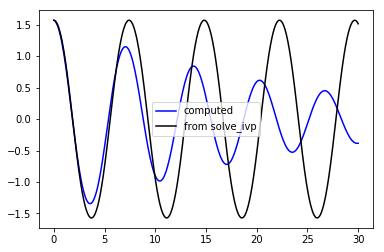

In [11]:
def BackwardEuler(nsteps):
    t0 = 0.;  tfinal = 30.
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    # Array for computed solution
    # give it two rows so each column is solution at one time,
    
    U = empty((2,nsteps+1))
    U.fill(nan)
    U[0,0] = theta0  # initial angle theta
    U[1,0] = 0.  # initial angular velocity
    for n in range(0,nsteps):
        phi = lambda theta: theta + dt**2*sin(theta) - (U[0,n]  + dt*U[1,n])
        new_theta = fsolve(phi, U[0,n])
        U[0,n+1] = new_theta
        U[1,n+1] = U[1,n] - dt * sin(new_theta)
    
    return t,U

t,U = BackwardEuler(300)

plot(t,U[0,:],'b',label='computed')
plot(t_eval,theta_eval,'k',label='from solve_ivp')
legend()
print('Error at the final time = %g' % abs(U[0,-1]-theta_eval[-1]))

We see that oscillations are decaying because the roots of the characteristic polynomial of the linearized equation are purely imaginary, so they are inside the stability region of the Backward Euler method

100%|██████████| 5/5 [05:04<00:00, 60.87s/it]


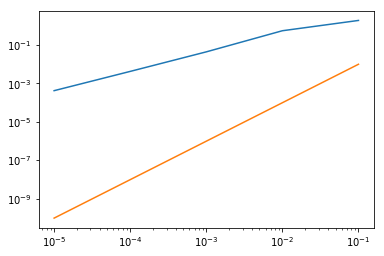

In [19]:
stepsizes = array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
errors = []
for h in tqdm(stepsizes):
    numsteps = int(30/h)
    t,U = BackwardEuler(numsteps)
    errors.append(abs(U[0,-1]-theta_eval[-1]))

Text(0, 0.5, 'E, the solution error at the last point')

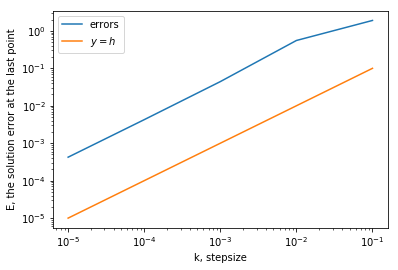

In [30]:
loglog(stepsizes, errors, label="errors")
loglog(stepsizes, stepsizes, label=r"$y=h$")
legend()
xlabel("k, stepsize")
ylabel("E, the solution error at the last point")

We see, that this method (the blue line) exhibits the first order accuracy. The orange line is a reference line y = x.

# Trapezoidal Method

First we derive an iteration of the Trapezoidal method for this problem

$\theta^{n+1} = \theta^n + \frac{k}{2}\left(v^n + v^{n+1}\right)$

$v^{n+1} = v^n - \frac{k}{2}\left(\sin(\theta^n) + \sin(\theta^{n+1}\right)$

$\theta^{n+1} = \theta^n +\frac{k}{2}\left(v^n + v^n - \frac{k}{2}\left(\sin\theta^n + \sin\theta^{n+1}\right) \right)$

So the function, roots of which are the updates for $\theta$ are

$\phi(\theta) = \theta - \theta^n - \frac{k}{2}\left(2v^n - \frac{k}{2}\left(\sin\theta^n + \sin\theta \right)\right)$

Error at the final time = 0.00552811


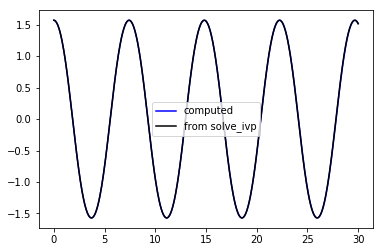

In [14]:
def Trapezoidal(nsteps):
    t0 = 0.;  tfinal = 30.
    t = linspace(t0, tfinal, nsteps+1)
    dt = t[1] - t[0]
    
    # Array for computed solution
    # give it two rows so each column is solution at one time,
    
    U = empty((2,nsteps+1))
    U.fill(nan)
    U[0,0] = theta0  # initial angle theta
    U[1,0] = 0.  # initial angular velocity
    for n in range(0,nsteps):
        phi = lambda theta: theta - U[0, n] - dt/2*(2*U[1, n] - dt/2*(sin(U[0, n]) + sin(theta)))
        new_theta = fsolve(phi, U[0,n])
        U[0,n+1] = new_theta
        U[1,n+1] = U[1,n] - dt/2 * (sin(U[0, n]) + sin(new_theta))
    
    return t,U

t,U = Trapezoidal(300)

plot(t,U[0,:],'b',label='computed')
plot(t_eval,theta_eval,'k',label='from solve_ivp')
legend()
print('Error at the final time = %g' % abs(U[0,-1]-theta_eval[-1]))

The solution from the Trapezoidal method neither blows up nor decays, as all the roots of the characteristic polynomial lie on the boundary of the method's stability region 

In [21]:
stepsizes = array([1e-1, 1e-2, 1e-3, 1e-4])
errors_trap = []
for h in tqdm(stepsizes):
    numsteps = int(30/h)
    t,U = Trapezoidal(numsteps)
    errors_trap.append(abs(U[0,-1]-theta_eval[-1]))

 40%|████      | 2/5 [00:00<00:00,  4.14it/s]/Users/aksholokhov/.anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
100%|██████████| 5/5 [07:29<00:00, 89.84s/it]


Text(0, 0.5, 'E, the solution error at the last point')

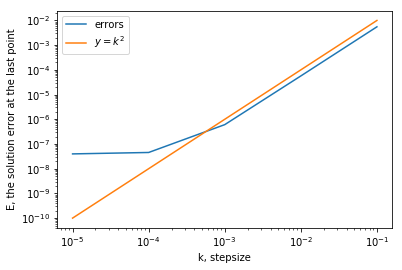

In [31]:
loglog(stepsizes, errors_trap, label="errors")
loglog(stepsizes, stepsizes**2, label=r"$y=k^2$")
legend()
xlabel("k, stepsize")
ylabel("E, the solution error at the last point")

We see, that this method (the blue line) exhibits the second order accuracy up to a small error, where $k^2 \sim \varepsilon_{machine}$. The orange line is a reference line y = k^2